[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets -q

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [9]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
                        if word not in stops
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
from pandas.compat import numpy
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [18]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch = 10) -> dict:
    # Напишите код здесь
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        print('train_loss:', epoch_losses[-1])
            
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, train_dataloader)[0])

        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)

    history = {
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity':val_perplexities
        }
    return history

Функция для вывода графиков

In [31]:
import matplotlib.pyplot as plt

def plot_result(history, model_name):
    print(model_name)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.3f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.3f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [34]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]      
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [29]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 20

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6753487586975098


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.406960964202881


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.253024101257324


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.101396083831787


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0035719871520996


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.8897628784179688


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7913436889648438


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7233184576034546


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.660890817642212


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.5757575035095215


Увеличим размер скрытого состояния

In [ ]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 20

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Попробуем Bidirectional GRU с размером скрытого слоя 2

In [ ]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 20

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [23]:
# Проведите второй эксперимент
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = x.permute(1, 0) # swap dimensions back
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [25]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.024185899645090103


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.007208219729363918


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0037787328474223614


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.002402432030066848


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0016671100165694952


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0012054844992235303


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0009294206975027919


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0007412796257995069


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0006013676756992936


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0004896243335679173


LanguageModelLinear


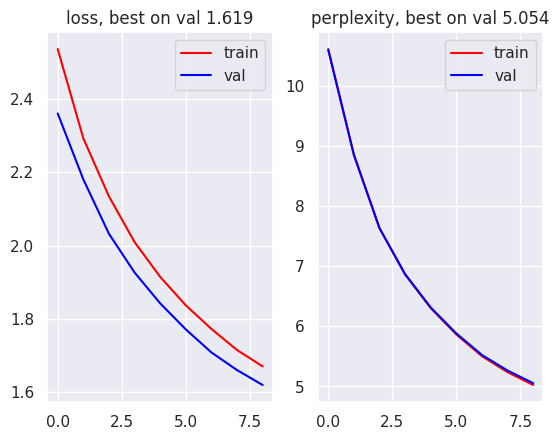

LanguageModelConv


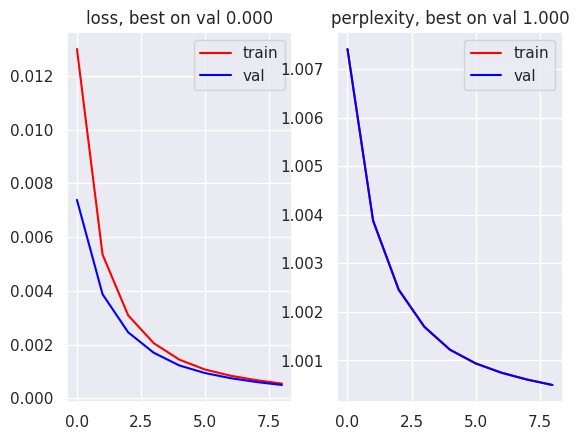

In [32]:
plot_result(history1, 'Language Model Linear размер скрытого слоя 1')
plot_result(history2, 'Language Model Linear размер скрытого слоя 2')
plot_result(history3, 'Language Model Linear Bidirectional GRU с размером скрытого слоя 2')
plot_result(history4, 'Language Model Conv Before GRU')

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 